Download dataset : https://drive.google.com/drive/folders/1_1VUX0ORKvdo5M3Gyv8HLAfCEbx_QTC5?usp=sharing

In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from tensorflow import keras

import utils

plt.rcParams['figure.figsize'] = (25, 8)
plt.rcParams["figure.autolayout"] = True

# Audio to Vec

In [2]:
import tensorflow as tf
import pathlib
import tensorflow_io as tfio

In [3]:
music_root = pathlib.Path('./music_data/')

In [4]:
for item in music_root.glob("*"):
  print(item.name)

acoustic
afrobeat
alt-rock
alternative
ambient
anime
black-metal
bluegrass
blues
brazil
breakbeat
british
cantopop
chicago-house
children
chill
classical
club
comedy
country
dance
dancehall
death-metal
deep-house
detroit-techno
disco
drum-and-bass
dub
dubstep
edm
electro
electronic
emo
folk
forro
french
funk
garage
german
gospel
goth
grindcore
groove
grunge
guitar
happy
hard-rock
hardcore
hardstyle
heavy-metal
hip-hop
honky-tonk
house
idm
indian
indie
indie-pop
industrial
iranian
j-dance
j-idol
j-pop
j-rock
jazz
k-pop
kids
latin
latino
malay
mandopop
metal
metalcore
minimal-techno
mpb
new-age
opera
pagode
party
piano
pop
pop-film
power-pop
progressive-house
psych-rock
punk
punk-rock
r-n-b
reggae
reggaeton
rock
rock-n-roll
rockabilly
romance
sad
salsa
samba
sertanejo
show-tunes
singer-songwriter
ska
sleep
songwriter
soul
spanish
study
swedish
synth-pop
tango
techno
trance
trip-hop
turkish
world-music


In [5]:
list_ds = tf.data.Dataset.list_files(str(music_root/'*/*'))

In [6]:
def parse_chroma(audio_path):
  label = tf.strings.split(audio_path, os.sep)
  label = label[-2].numpy().decode('utf-8')
  x, sr = librosa.load(audio_path.numpy().decode('utf-8'), sr=None, mono=True,offset=0.0, duration=3.0)
  chroma = librosa.feature.chroma_stft(y=x,sr=sr)
  return chroma, label

j-rock


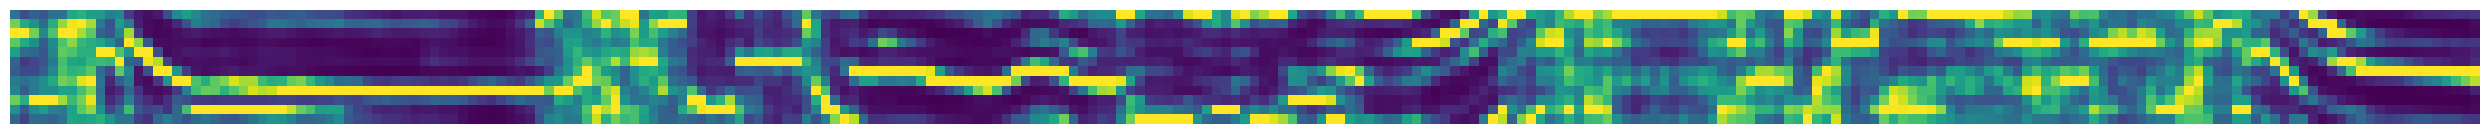

In [7]:
# test function parse_chroma
file_path = next(iter(list_ds))
chroma, label = parse_chroma(file_path)

def show(chroma, label):
  print(label)
  plt.imshow(chroma)
  plt.axis('off')

show(chroma, label)

j-rock


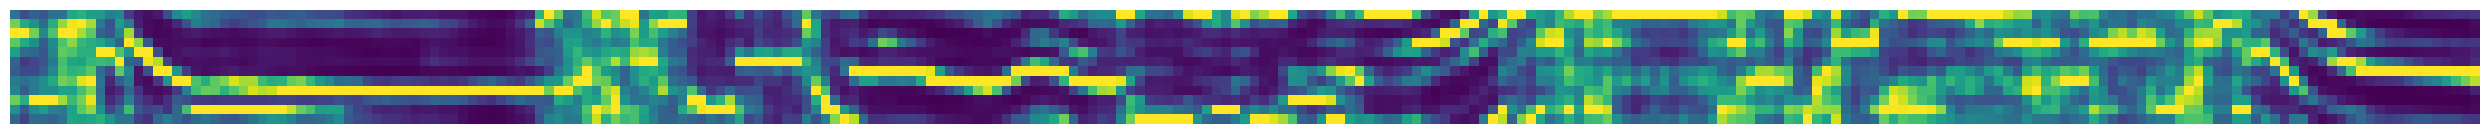

In [8]:
z = map(parse_chroma,[file_path])
q = np.array(list(z), dtype=object)
show(q[0][0], q[0][1])

In [9]:
classes = [item.name for item in music_root.glob("*")]

In [10]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

In [11]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

# Build CNN Model

In [12]:
from sklearn.model_selection import train_test_split

In [13]:

def onehot(y_str):
    nclass=len(classes)
    y_num = np.array([classes.index(y) for y in y_str])
    y_ = np.zeros((y_str.shape[0], nclass))
    for i, y in enumerate(y_num):
        y_[i, int(y)] = 1
    return y_

In [14]:
BATCH_FILES: int = 250

- โหลดไฟล์ wav และแปลงเป็น chroma feature (type vector)
- Add chroma feature to Numpy array

In [15]:

# # music_root : ./music_data/
# # list_files : music_root/*/*

# index_batch = 0
# iterate = 0
# batch_size = int(250/BATCH_FILES)

# for iterate in range(1, batch_size+1) :

#     x_dataset = []
#     y_dataset = []

#     for dir in music_root.glob("*"):
#         list_files = tf.data.Dataset.list_files(str(dir/'*'))
#         list_files = [i for i in list_files]

#         index_file = index_batch
#         while(index_file < iterate * BATCH_FILES):
#             item = list_files[index_file]
#             chroma, label = parse_chroma(item)
#             x_dataset.append(chroma)
#             y_dataset.append(label)
#             index_file += 1

#     index_batch += BATCH_FILES

#     x_dataset = np.array(x_dataset)
#     y_dataset = np.array(y_dataset)

#     x_dataset = x_dataset.reshape((*x_dataset.shape, 1))
#     y_dataset = onehot(y_dataset)

#     X_train, X_test, Y_train, Y_test = train_test_split(x_dataset, y_dataset, train_size=0.75, stratify=y_dataset)
#     X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.8, stratify=Y_train)

#     # CNNmodel.fit(X_train, Y_train, batch_size=10, epochs=20, validation_data=(X_test, Y_test), shuffle=True)


In [16]:
# save dataset-vec to file

# np.save('./dataset-vec/x.npy', x_dataset)
# np.save('./dataset-vec/y.npy', y_dataset)

In [17]:
# load dataset-vec

x_dataset = np.load('./dataset-vec/x.npy')
y_dataset = np.load('./dataset-vec/y.npy')

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(x_dataset, y_dataset, train_size=0.75, stratify=y_dataset)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.8, stratify=Y_train)

In [19]:
X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

28250

In [20]:
input_shape=(12, 259, 1)
CNNmodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(113, activation='softmax'),
])

CNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 259, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 129, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 127, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 62, 32)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1984)              0

In [21]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-6)

CNNmodel.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [22]:
history = CNNmodel.fit(X_train, Y_train, batch_size=250, epochs=20, validation_data=(X_val, Y_val), shuffle=True)

Epoch 1/20
68/68 [==============================] - 20s 288ms/step - loss: 4.7124 - accuracy: 0.0104 - val_loss: 4.6997 - val_accuracy: 0.0156
Epoch 2/20
68/68 [==============================] - 19s 276ms/step - loss: 4.6238 - accuracy: 0.0185 - val_loss: 4.5346 - val_accuracy: 0.0203
Epoch 3/20
68/68 [==============================] - 19s 275ms/step - loss: 4.5158 - accuracy: 0.0234 - val_loss: 4.4675 - val_accuracy: 0.0311
Epoch 4/20
68/68 [==============================] - 19s 276ms/step - loss: 4.4529 - accuracy: 0.0293 - val_loss: 4.4181 - val_accuracy: 0.0392
Epoch 5/20
68/68 [==============================] - 19s 279ms/step - loss: 4.3618 - accuracy: 0.0430 - val_loss: 4.3199 - val_accuracy: 0.0503
Epoch 6/20
68/68 [==============================] - 19s 282ms/step - loss: 4.2500 - accuracy: 0.0593 - val_loss: 4.2622 - val_accuracy: 0.0533
Epoch 7/20
68/68 [==============================] - 19s 281ms/step - loss: 4.1143 - accuracy: 0.0729 - val_loss: 4.2090 - val_accuracy: 0.0651

In [133]:
CNNmodel.evaluate(X_test, Y_test)

221/221 [==============================] - 1s 6ms/step - loss: 4.3099 - accuracy: 0.1025


[4.309893608093262, 0.10250601917505264]

In [134]:
pred = CNNmodel.predict(X_test)

221/221 [==============================] - 1s 6ms/step


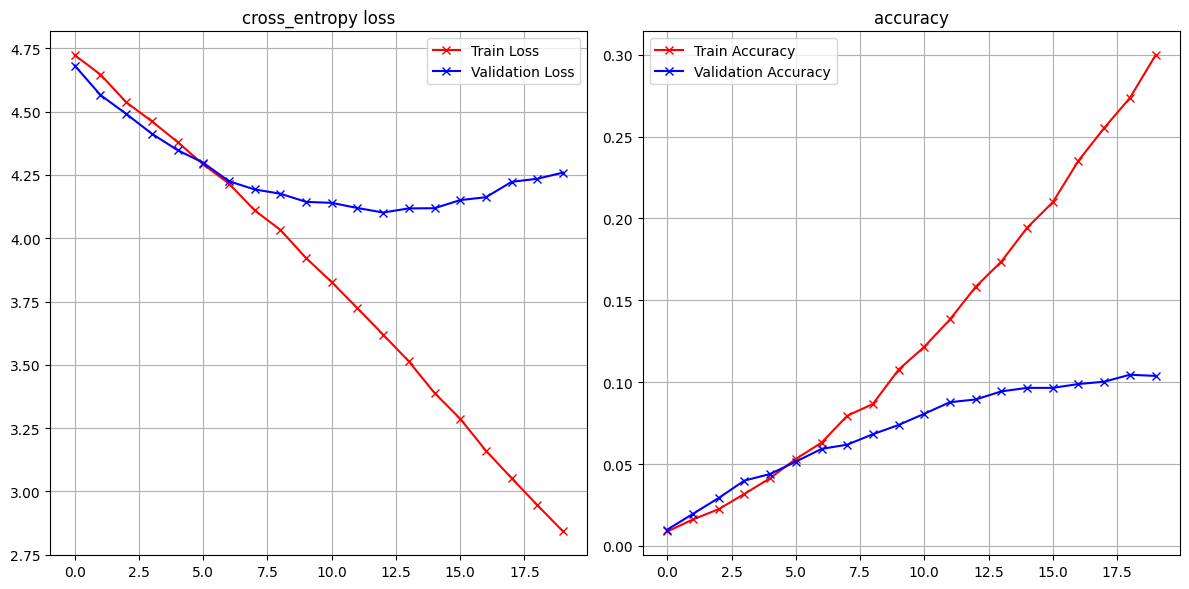

In [135]:
plot_loss_accuracy(history)